## Download soilgrids SOC data and propagate uncertainty across 0-5cm, 5-15cm, and 15-30cm layers

Serge Wiltshire, 5/13/24

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from soilgrids import SoilGrids
import rasterio as rio  
soil_grids = SoilGrids()

Function to download soilgrids data

In [8]:
def dl_sg(cov):
    sg_data = soil_grids.get_coverage_data(
        service_id='soc',
        coverage_id=cov,
        west=-19949000.0, #-1784000,
        south=-6147500.0, #1356000,
        east=19861750.0, #-1140000,
        north=8361000.0, #1863000,
        resx=3000, # max size of raster is apparently 16384 pixels in each direction, so this (3km) is essentially the max resolution...
        resy=3000,
        crs="urn:ogc:def:crs:EPSG::152160",
        output = cov + ".tif",
        local_file = True # if true, tries to load a previously saved tif named same as above
    )
    return sg_data


Function to convert to soilgrids class to 2d numpy array

In [3]:
def sg_to_np(sg_data):
    np_data = sg_data.values
    np_data = np_data.reshape(np_data.shape[1], np_data.shape[2]).astype('float') # reshape to 2d
    np_data[np_data == sg_data._FillValue] = np.nan # replace fill value (used for water, etc.) with nan
    return np_data

Functions to plot numpy data

In [4]:
def plot_np_sg(np_data, filename):
    plt.imshow(np_data, cmap = 'viridis' , interpolation = 'none')
    plt.axis('off')
    plt.colorbar()
    fig = plt.gcf()
    fig.set_size_inches(11,3)
    # plt.show()
    fig.savefig(filename + '.png', bbox_inches='tight', dpi=600)
    plt.close("all")

# plot_np_sg(np_data_dict['soc_0-5cm_mean'], 'null')

def plot_hist(data, label):
    plt.hist(data, bins=30, color='skyblue', edgecolor='black')
    
    # Adding labels and title
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram: ' + label)
    
    # Display the plot
    plt.show()

Coverages (maps) we're interested in

In [5]:
covs = ['soc_0-5cm_mean', 'soc_0-5cm_Q0.5', 'soc_0-5cm_uncertainty', 
        'soc_5-15cm_mean', 'soc_5-15cm_Q0.5', 'soc_5-15cm_uncertainty', 
        'soc_15-30cm_mean', 'soc_15-30cm_Q0.5', 'soc_15-30cm_uncertainty']

Do the downloads and conversions

In [9]:
sg_data_dict = {}

for cov in covs:
    print('Downloading SG data: ' + cov)
    sg_data_dict[f"{cov}"] = dl_sg(cov)


Save downloaded data to pickle

In [10]:
with open("sg_data_dict.p", "wb") as file:
    pickle.dump(sg_data_dict, file)

Load downloaded data from pickle

In [9]:
with open('sg_data_dict.p', 'rb') as file:
    sg_data_dict = pickle.load(file)

Convert tif to numpy

In [11]:
np_data_dict = {}

for key, value in sg_data_dict.items():
    print('Converting SG data to Numpy: ' + key)
    np_data_dict[key] = sg_to_np(value)

Converting SG data to Numpy: soc_0-5cm_mean
Converting SG data to Numpy: soc_0-5cm_Q0.05
Converting SG data to Numpy: soc_0-5cm_uncertainty
Converting SG data to Numpy: soc_5-15cm_mean
Converting SG data to Numpy: soc_5-15cm_Q0.05
Converting SG data to Numpy: soc_5-15cm_uncertainty
Converting SG data to Numpy: soc_15-30cm_mean
Converting SG data to Numpy: soc_15-30cm_Q0.05
Converting SG data to Numpy: soc_15-30cm_uncertainty


Plot each to make sure we're on the right track

In [12]:
for key, value in np_data_dict.items():
    print('Plotting ' + key)
    plot_np_sg(value, key)

Plotting soc_0-5cm_mean
Plotting soc_0-5cm_Q0.05
Plotting soc_0-5cm_uncertainty
Plotting soc_5-15cm_mean
Plotting soc_5-15cm_Q0.05
Plotting soc_5-15cm_uncertainty
Plotting soc_15-30cm_mean
Plotting soc_15-30cm_Q0.05
Plotting soc_15-30cm_uncertainty


Flatten each 2d array to vector

In [13]:
np_data_dict_flat = np_data_dict.copy()

for key in np_data_dict_flat:
    print(np_data_dict_flat[key].shape)
    np_data_dict_flat[key] = np_data_dict_flat[key].flatten()
    print(np_data_dict_flat[key].shape)

# store vector length for later
vec_len = 64173720

(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)
(4836, 13270)
(64173720,)


Plot histograms of uncertainty vectors as reported

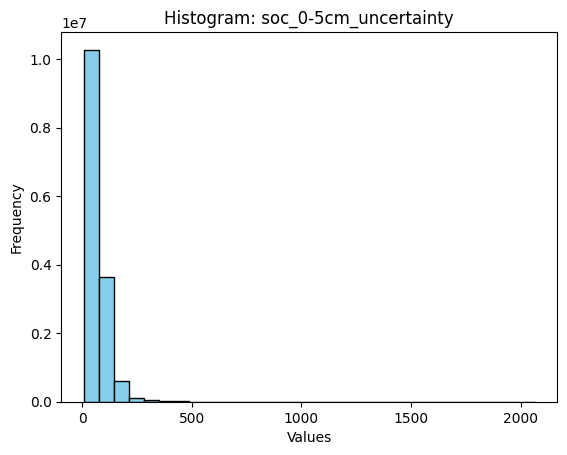

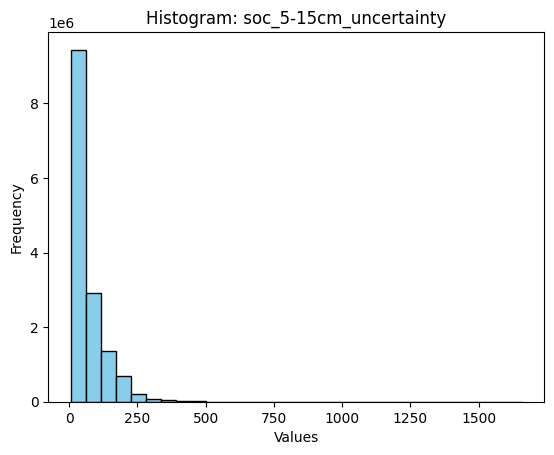

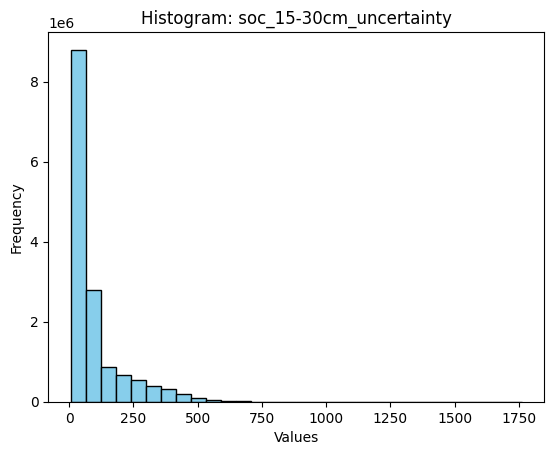

In [14]:
for key, value in np_data_dict_flat.items():
    if 'uncertainty' in key:
        plot_hist(value, key)

Convert reported uncertainty (inter-quartile range / median ratio) to SD

"The additional uncertainty layer displayed at soilgrids.org is the ratio between the inter-quantile range (90% prediction interval width) and the median : (Q0.95-Q0.05)/Q0.50. The values are multiplied by 10 in order to have integers and reduce the size of the datasets."

In [15]:

def iqr_rat_to_sd(median, iqr_rat):
    return iqr_rat / 10 * median / (1.645*2)

np_data_dict_flat['soc_0-5cm_sd'] = np.zeros(vec_len)
np_data_dict_flat['soc_5-15cm_sd'] = np.zeros(vec_len)
np_data_dict_flat['soc_15-30cm_sd'] = np.zeros(vec_len)

for i in range(vec_len):
    median1 = np_data_dict_flat['soc_0-5cm_Q0.5'][i]
    iqr_rat1 = np_data_dict_flat['soc_0-5cm_uncertainty'][i]
    median2 = np_data_dict_flat['soc_5-15cm_Q0.5'][i]
    iqr_rat2 = np_data_dict_flat['soc_5-15cm_uncertainty'][i]
    median3 = np_data_dict_flat['soc_15-30cm_Q0.5'][i]
    iqr_rat3 = np_data_dict_flat['soc_15-30cm_uncertainty'][i]
    np_data_dict_flat['soc_0-5cm_sd'][i] = iqr_rat_to_sd(median1, iqr_rat1)
    np_data_dict_flat['soc_5-15cm_sd'][i] = iqr_rat_to_sd(median2, iqr_rat2)
    np_data_dict_flat['soc_15-30cm_sd'][i] = iqr_rat_to_sd(median3, iqr_rat3)


Plot histograms of sd vectors

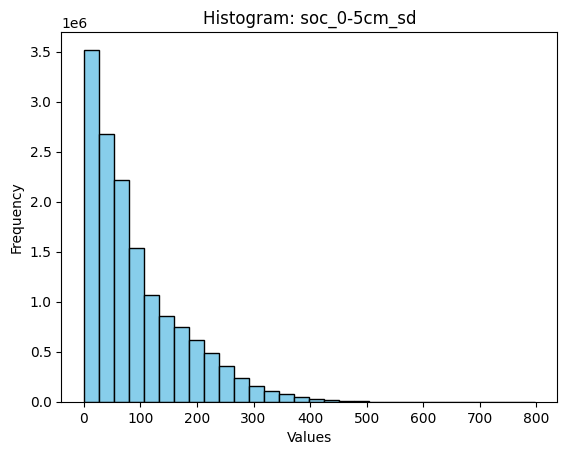

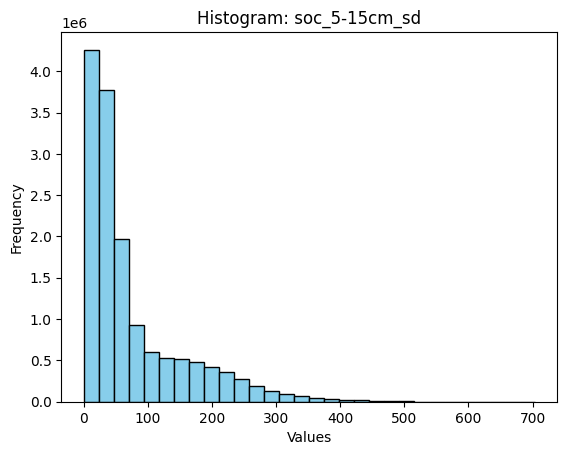

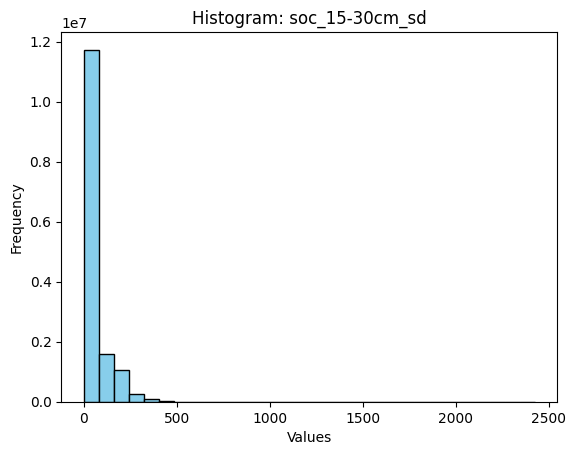

In [16]:
for key, value in np_data_dict_flat.items():
    if 'sd' in key:
        plot_hist(value, key)

Convert SDs to UC percent

In [17]:
def sd_to_uc(mean, sd):
    return (sd * 1.96 / mean) * 100 # 95% CI (90% CI is 1.645)

np_data_dict_flat['soc_0-5cm_uc_pct'] = np.zeros(vec_len)
np_data_dict_flat['soc_5-15cm_uc_pct'] = np.zeros(vec_len)
np_data_dict_flat['soc_15-30cm_uc_pct'] = np.zeros(vec_len)

for i in range(vec_len):
    mean1 = np_data_dict_flat['soc_0-5cm_mean'][i]
    sd1 = np_data_dict_flat['soc_0-5cm_sd'][i]
    mean2 = np_data_dict_flat['soc_5-15cm_mean'][i]
    sd2 = np_data_dict_flat['soc_5-15cm_sd'][i]
    mean3 = np_data_dict_flat['soc_15-30cm_mean'][i]
    sd3 = np_data_dict_flat['soc_15-30cm_sd'][i]
    np_data_dict_flat['soc_0-5cm_uc_pct'][i] = sd_to_uc(mean1, sd1)
    np_data_dict_flat['soc_5-15cm_uc_pct'][i] = sd_to_uc(mean2, sd2)
    np_data_dict_flat['soc_15-30cm_uc_pct'][i] = sd_to_uc(mean3, sd3)


Plot histograms of uncertainty percent vectors

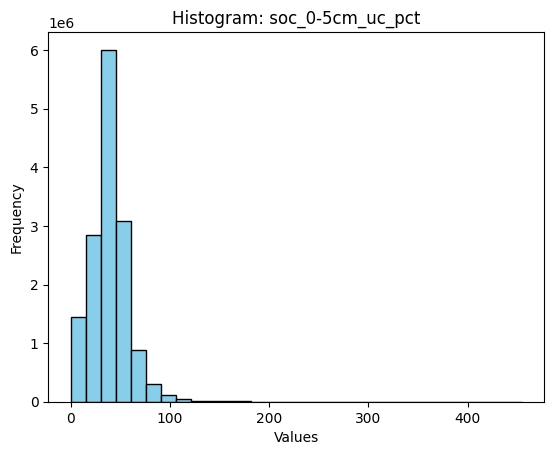

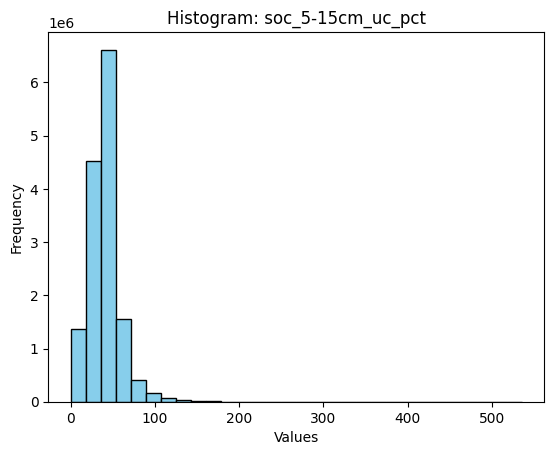

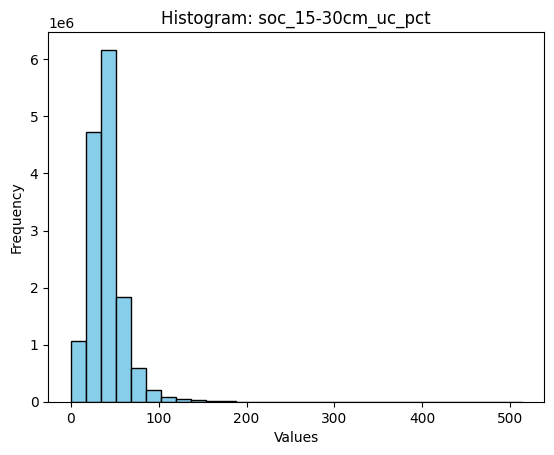

In [18]:
for key, value in np_data_dict_flat.items():
    if 'uc_pct' in key:
        plot_hist(value, key)

Save computed vector data to pickle

In [19]:
with open("np_data_dict_flat.p", "wb") as file:
    pickle.dump(np_data_dict_flat, file)

Load computed vector data from pickle

In [ ]:
with open('np_data_dict_flat.p', 'rb') as file:
    np_data_dict_flat = pickle.load(file)

Error propagation formula

In [20]:
def add_uc(mean1, uc1, mean2, uc2, mean3, uc3):
    return math.sqrt((uc1*mean1)**2 + (uc2*mean2)**2 + (uc3*mean3)**2) / abs(mean1 + mean2 + mean3)

In [27]:
# testing
add_uc(5,20,4,30,6,10)

11.155467020454342

Calculate propagated uncertainty for each cell

In [21]:
vec_len = 64173720
# vec_len = 5000

comb_uc_vec = np.zeros(vec_len)

for i in range(vec_len):
    mean1 = np_data_dict_flat['soc_0-5cm_mean'][i]
    uc1 = np_data_dict_flat['soc_0-5cm_uc_pct'][i]
    mean2 = np_data_dict_flat['soc_5-15cm_mean'][i]
    uc2 = np_data_dict_flat['soc_5-15cm_uc_pct'][i]
    mean3 = np_data_dict_flat['soc_15-30cm_mean'][i]
    uc3 = np_data_dict_flat['soc_15-30cm_uc_pct'][i]
    comb_uc_vec[i] = add_uc(mean1, uc1, mean2, uc2, mean3, uc3)


Save combined uncertainty data to pickle

In [22]:
with open("comb_uc_vec.p", "wb") as file:
    pickle.dump(comb_uc_vec, file)

Load combined uncertainty data from pickle

In [151]:
with open('comb_uc_vec.p', 'rb') as file:
    comb_uc_vec = pickle.load(file)

Investigate error distribution

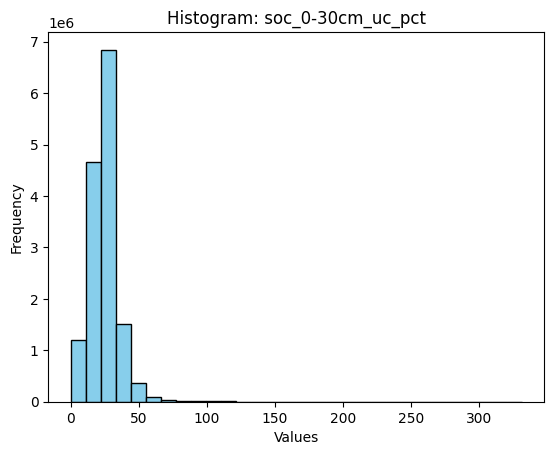

In [23]:
plot_hist(comb_uc_vec, 'soc_0-30cm_uc_pct')

What is the mean uncertainty?

In [24]:
print(np.nanmean(comb_uc_vec))
print(np.nanmedian(comb_uc_vec))

24.41530688749517
23.884293935252682


Convert vector back to 2d array

In [25]:
comb_uc_2d = comb_uc_vec.reshape(4836, 13270)

Plot combined uc data

In [26]:
plot_np_sg(comb_uc_2d, 'soc_0-30cm_uc_pct')

Convert array back to tif

In [27]:
# reset na value
na_val = sg_data_dict['soc_0-5cm_uncertainty']._FillValue # no data value of original rasters is -32768
comb_uc_2d_repnan = np.nan_to_num(comb_uc_2d, nan = na_val)

# use existing tif to get extent and resolution
with rio.open('soc_0-5cm_uncertainty.tif') as src:
    ras_data = src.read()
    ras_meta = src.profile

# make any necessary changes to raster properties, e.g.:
# ras_meta['dtype'] = "int32"
# ras_meta['nodata'] = -32768

# write new data to raster and save
with rio.open('soc_0-30cm_uc_pct.tif', 'w', **ras_meta) as dst:
    dst.write(comb_uc_2d_repnan, 1)